In [77]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from TO_sim.Sol_Kuramoto import Sol_Kuramoto_mK as mK
from TO_sim.Sol_Kuramoto import Sol_Kuramoto_mf2 as mf2
from TO_sim.get_cluster import C_rsmso,cluster_os
from TO_sim.To_Draw import Draw_avg_vel_r

from TO_sim.gen_Distribution import Normal
from TO_sim.gen_Distribution import Quantile_Normal as Q_Normal
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from tqdm.notebook import tqdm
from scipy.signal import find_peaks
import parmap

In [2]:
seed =10
N = 500
theta_init,omega,Kc = Normal(N,0,1,seed=seed)
omega = np.sort(omega) 
K = 5
m = 5
t_end = 5000
dt =0.1
t = np.arange(0,t_end,dt)
theta, dtheta,rs = mf2(K,N=N,m=m,t_array=t,p_theta=theta_init,p_dtheta= 0*omega,p_omega=omega,result_time = int((t_end)-(600))*int(1/dt))
if m == 0:
        dtheta = np.c_[dtheta[0],dtheta.T].T

In [63]:
dtheta_c = np.cumsum(dtheta,axis=0)
r_c = np.cumsum(rs,axis=0)
sum_time = 500*int(1/dt)
t_sum = t[sum_time:]
avg_dtheta = (dtheta_c[sum_time:]-dtheta_c[:-sum_time])/sum_time
avg_r = (r_c[sum_time:]-r_c[:-sum_time])/sum_time

In [64]:
CS,CO,Cidx = cluster_os(avg_dtheta,N,cidx=True,dt=dt)
print(*CS)
print(*CO)

19.0 373.0 38.0
-0.9995196042573798 0.021534197346123635 1.0426765993986287


/Users/kimgug-young/Desktop/KURAMOTO 1st order/Kuramoto-model/TO_sim/get_cluster.py:74: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  C_idx = np.array([arg[i] for i in clusters[sCM_Oidx]])


In [65]:
def to_cluster_barg(idx,peaks_new):
    C = idx,idx+1
    arg_C = peaks_new[C[0]],peaks_new[C[1]]
    cluster = np.arange(arg_C[0],arg_C[1])
    return cluster
def to_cstability(x,diff_dtheta):
    try:
        return np.mean(diff_dtheta[x[1:]])
    except IndexError:
        return np.nan
def to_mean_avg_d_o(x,avg_dtheta,index):
    try:
        return np.mean(avg_dtheta[index][x])
    except IndexError:
        return np.nan
iter_time = 20*int(1/dt)*5
num = 0
for index in range(-iter_time,0):
    arg = np.argsort(avg_dtheta[index])
    SD = avg_dtheta[index][arg]
    diff_dtheta = np.diff([SD[0],*SD,SD[-1]])
    peaks, P  = find_peaks(diff_dtheta, height=0.02)
    
    # peaks = peaks[np.where((peaks<N)&(peaks>1))]

    try:
        if len(peaks) == 1:
            peaks_new = np.array([peaks[0],N])
        else:
            peaks_new = np.array([peaks[0],*peaks])
    except IndexError:
        peaks_new = np.array([0,N])
    psize = np.diff(peaks_new)
    arg_psize = np.argsort(psize)[::-1]
    sort_psize = np.sort(psize)[::-1]
    clusters = np.array([to_cluster_barg(arg,peaks_new) for arg in arg_psize],dtype=object)[:10]
    try:
        if len(clusters) == 1:
            clusters = np.array([np.arange(peaks_new[0],N)])
        c_stability = np.array(list(map(to_cstability,clusters,[diff_dtheta]*len(clusters))))
        mean_omega = np.array(list(map(to_mean_avg_d_o,clusters,[avg_dtheta]*len(clusters),[index]*len(clusters))))
        if num==0:
            psize_array = sort_psize[:10]
            cluster_array = clusters
            c_stability_array = c_stability
            mean_omega_array = mean_omega
            arg_array = arg

            num+=1
        else:
            cluster_array = np.c_[cluster_array,clusters]
            psize_array = np.c_[psize_array,sort_psize[:10]]
            c_stability_array = np.c_[c_stability_array,c_stability]
            mean_omega_array = np.c_[mean_omega_array,mean_omega]
            arg_array = np.c_[arg_array,arg]
    except ValueError:
        pass

        

Is_group = np.where((np.std(psize_array,axis=1) <= 0)&(psize_array[:,-1]>10))
mean_group_s = np.mean(c_stability_array,axis=1)
Is_group_s = np.where((mean_group_s<1e-3)&(psize_array[:,-1]>5))

CM_O = np.mean(mean_omega_array[Is_group],axis=1)
sCM_O = np.sort(CM_O)
sCM_Oidx = np.argsort(CM_O)

CM_S = np.mean(psize_array[Is_group],axis=1)[sCM_Oidx]

In [66]:
Is_group_s,Is_group

((array([0, 1, 2]),), (array([0, 1, 2]),))

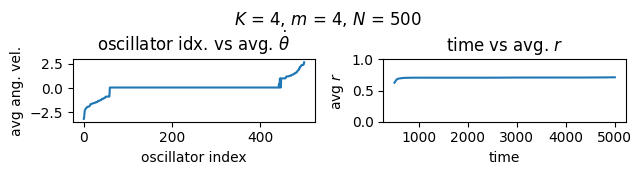

In [49]:
Draw_avg_vel_r(t_sum=t_sum,avg_r=avg_r,KmN=(K,m,N),avg_dtheta=avg_dtheta,Cidx=[])

In [10]:
for K in range(7,9):
    r,rstd,rMM,CSO = C_rsmso(K,m,N,theta_init,omega,0*omega)
    print(K,CSO)

7 [(499, 0.03410577)]
8 [(500, 0.03100999)]


In [27]:
Ks

array([1., 2., 3., 4., 5.])

In [29]:
K = 4
m = 4
r,rstd,rMM,CSO = C_rsmso(K,m,N,theta_init,omega,0*omega)
print(K,CSO)

4 []


In [5]:
RE_CSO = CSO.copy()
M_arg = np.argmin(abs(CSO['cluster mean phase velocity']))
M_p = CSO[M_arg]['cluster mean phase velocity']
RE_CSO['cluster mean phase velocity'] = CSO['cluster mean phase velocity']

In [3]:
Ks = np.arange(0,5,0.1)
ms = np.arange(0,2,0.1)
KK,MM = np.meshgrid(Ks,ms)
cols ={'r':[0],'rstd':[0],'rMM':[0]}
for i in range(10):
    cols[f'c{i}'] = np.nan
for i in range(10):
    cols[f'c{i} omega'] = np.nan


for i in range(10):
    cols[f'S c{i}'] = np.nan
for i in range(10):
    cols[f'S c{i} omega'] = np.nan
cols['K'] = Ks[0]
cols['m'] = ms[0]
df = pd.DataFrame(cols)
df_Km = df.set_index(['K','m'])

In [4]:

for i in range(5):
    ms = np.arange(0+2*i,2+2*i,0.1)
    for i in range(2):
        Ks = np.arange(0+5*i,5+5*i,0.1) 
        KK,MM = np.meshgrid(Ks,ms)
        for K_,M_ in tqdm(list(zip(KK,MM))):
            for K,m,(r,rstd,rMM,CSO) in zip(K_,M_,parmap.starmap(C_rsmso,zip(K_,M_),N=N,theta_init=theta_init,omega=omega,pdtheta=0*omega, pm_processes=15)):
                RE_CSO = CSO.copy()
                RE_CSO['cluster mean phase velocity'] = CSO['cluster mean phase velocity']
                df_Km.loc[(K,m),"r"] = r
                df_Km.loc[(K,m),"rstd"] = rstd
                df_Km.loc[(K,m),"rMM"] = rMM
                for i in range(len(CSO)):
                    df_Km.loc[(K,m),f'c{i}'] = CSO['cluster size'][i]
                    df_Km.loc[(K,m),f'c{i} omega'] = CSO['cluster mean phase velocity'][i]
                    df_Km.loc[(K,m),f'S c{i}'] = RE_CSO['cluster size'][i]
                    df_Km.loc[(K,m),f'S c{i} omega'] = RE_CSO['cluster mean phase velocity'][i]


  0%|          | 0/20 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dty

  0%|          | 0/20 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dty

  0%|          | 0/20 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dty

  0%|          | 0/20 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dty

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dty

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dty

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [5]:
df_Km.to_excel('TEMP 230620.xlsm')

In [15]:
df_Km.reset_index().to_excel('TEMP 230620.xlsm')

In [19]:
KK = df_Km.index.to_frame().K.unstack().to_numpy().T
MM = df_Km.index.to_frame().m.unstack().to_numpy().T

In [ ]:
plt.imshow()

In [18]:
df_Km.sort_index().to_excel('test 230620.xlsm')

In [76]:
# plt.pcolormesh(KK,MM,abs(df_Km['S c0 omega'].unstack()).T)
# plt.pcolormesh(KK,MM,df_Km['rstd'].unstack().T)
plt.pcolormesh(KK,MM,abs(df_Km['S c1 omega']).unstack().T)
plt.colorbar()


<IPython.core.display.Javascript object>

KeyError: 'figure.hooks'

In [49]:
Ks = df_Km.reset_index().K
ms = df_Km.reset_index().m
Ss = df_Km.reset_index()['S c1']
So = df_Km.reset_index()['S c1 omega']

In [ ]:
plt.scatter(KK,MM,df_Km['S c1 omega'].unstack().T,abs(df_Km['S c1'].unstack().T))


In [75]:


plt.subplot(projection='3d')
# ax = fig.add_subplot(projection='3d')
plt.scatter(Ks,ms,Ss,So*0.01)
# plt.show()


<IPython.core.display.Javascript object>

KeyError: 'figure.hooks'

<IPython.core.display.Javascript object>

In [64]:
plt.subplot(projection='3d')
# ax = fig.add_subplot(projection='3d')
plt.scatter(Ks,ms,Ss,So*0.01)

<IPython.core.display.Javascript object>

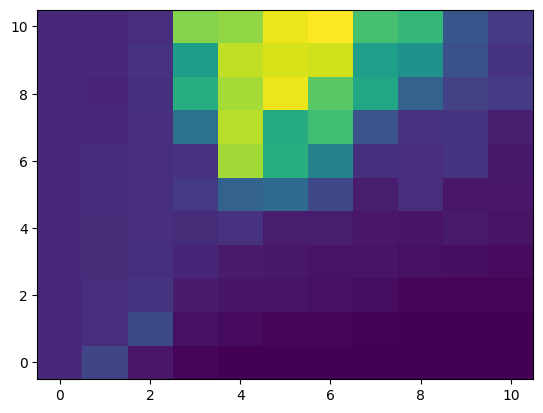

In [39]:
# plt.imshow(df_Km['S c0'].unstack().T)
plt.pcolormesh(KK,MM,df_Km['S c0'].unstack().T)
plt.pcolormesh(KK,MM,df_Km['r'].unstack().T)
plt.pcolormesh(KK,MM,df_Km['rstd'].unstack().T)
# plt.imshow(df_Km['r'].unstack().T)
# plt.imshow(df_Km['rstd'].unstack().T)

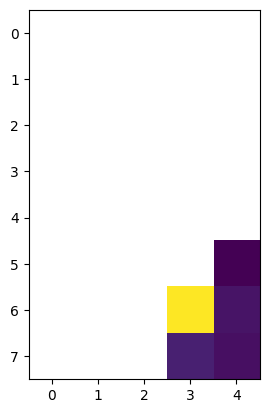

In [24]:
plt.imshow(df_Km['S c2'].unstack().T)